In [549]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
import numpy as np


In [550]:
# Load the dataset
file_path = 'combined_data.csv'  
combined_df = pd.read_csv(file_path)
combined_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5315 entries, 0 to 5314
Data columns (total 26 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   UPC 13 digit                      5315 non-null   int64  
 1   Geography                         5315 non-null   object 
 2   Time                              5315 non-null   object 
 3   Product_x                         5315 non-null   object 
 4   Unit Sales                        5315 non-null   float64
 5   Volume Sales                      5315 non-null   float64
 6   Dollar Sales                      5315 non-null   float64
 7   Total Ounces                      5315 non-null   float64
 8   Price per Unit                    5315 non-null   float64
 9   Package                           5315 non-null   object 
 10  Cooked Info                       5315 non-null   object 
 11  Price per Volume                  5315 non-null   float64
 12  Unit S

In [551]:
print(combined_df.isnull().sum())
combined_df.fillna(0, inplace=True)

UPC 13 digit                        0
Geography                           0
Time                                0
Product_x                           0
Unit Sales                          0
Volume Sales                        0
Dollar Sales                        0
Total Ounces                        0
Price per Unit                      0
Package                             0
Cooked Info                         0
Price per Volume                    0
Unit Sales Any Merch                0
Unit Sales Price Reductions Only    0
Unit Sales Feature Only             0
Unit Sales Display Only             0
Dollar Sales Any Merch              0
Dollar Sales Feature Only           0
Dollar Sales Display Only           0
Incremental Units                   0
Incremental Volume                  0
Incremental Dollars                 0
ACV Weighted Distribution           0
Flavor / Scent                      0
Form                                0
Brand Name                          0
dtype: int64

In [552]:
# Remove unnecessary text and parse the date
combined_df['Time'] = combined_df['Time'].str.replace('Week Ending', '').str.strip()
combined_df['Time'] = pd.to_datetime(combined_df['Time'], format='%m-%d-%y', errors='coerce')

In [553]:
# Check for parsing errors
print(combined_df[combined_df['Time'].isna()])

Empty DataFrame
Columns: [UPC 13 digit, Geography, Time, Product_x, Unit Sales, Volume Sales, Dollar Sales, Total Ounces, Price per Unit, Package, Cooked Info, Price per Volume, Unit Sales Any Merch, Unit Sales Price Reductions Only, Unit Sales Feature Only, Unit Sales Display Only, Dollar Sales Any Merch, Dollar Sales Feature Only, Dollar Sales Display Only, Incremental Units, Incremental Volume, Incremental Dollars, ACV Weighted Distribution, Flavor / Scent, Form, Brand Name]
Index: []

[0 rows x 26 columns]


In [554]:
combined_df['Year'] = combined_df['Time'].dt.year
combined_df['Month'] = combined_df['Time'].dt.month
combined_df['Quarter'] = combined_df['Time'].dt.quarter

In [555]:
combined_df['Price Ratio'] = combined_df['Price per Unit'] / combined_df['Price per Volume']

In [556]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5315 entries, 0 to 5314
Data columns (total 30 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   UPC 13 digit                      5315 non-null   int64         
 1   Geography                         5315 non-null   object        
 2   Time                              5315 non-null   datetime64[ns]
 3   Product_x                         5315 non-null   object        
 4   Unit Sales                        5315 non-null   float64       
 5   Volume Sales                      5315 non-null   float64       
 6   Dollar Sales                      5315 non-null   float64       
 7   Total Ounces                      5315 non-null   float64       
 8   Price per Unit                    5315 non-null   float64       
 9   Package                           5315 non-null   object        
 10  Cooked Info                       5315 non-null 

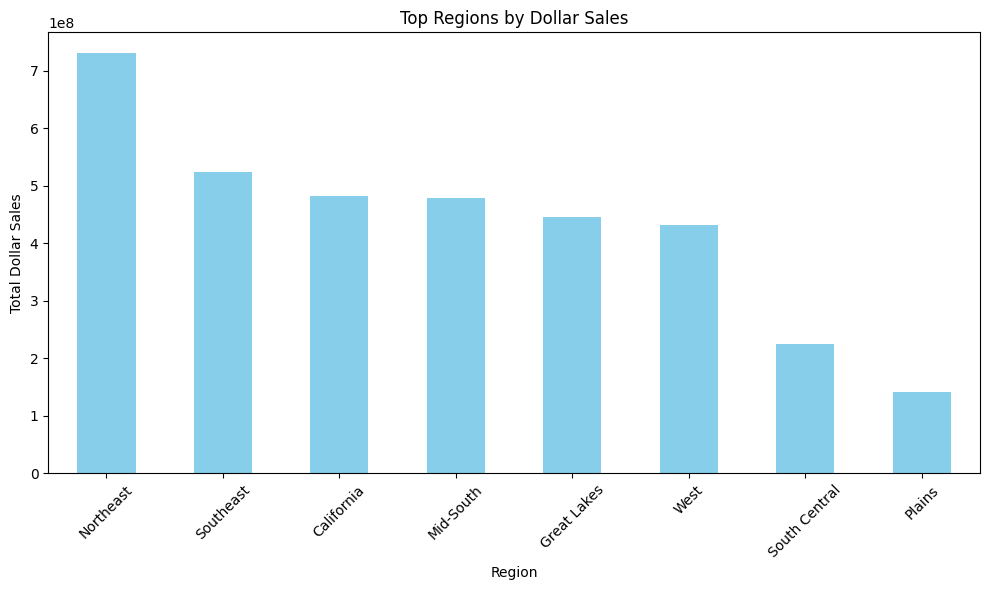

In [557]:
# 1. Top Regions by Dollar Sales
region_sales = combined_df.groupby('Geography')['Dollar Sales'].sum().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
region_sales.plot(kind='bar', color='skyblue')
plt.title('Top Regions by Dollar Sales')
plt.xlabel('Region')
plt.ylabel('Total Dollar Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

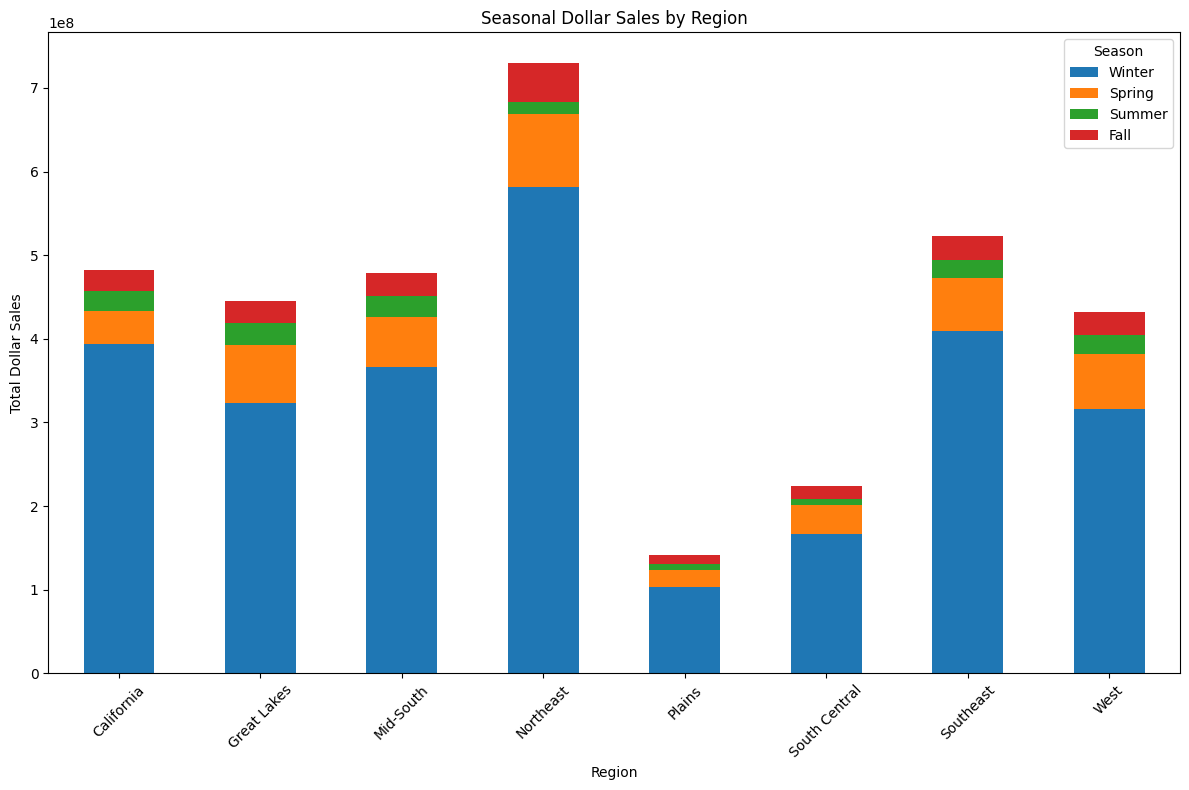

In [558]:
# 2. Seasonal Dollar Sales by Region
combined_df['Season'] = combined_df['Month'] % 12 // 3 + 1  # Map months to seasons (1: Winter, 2: Spring, 3: Summer, 4: Fall)
seasonal_sales = combined_df.groupby(['Geography', 'Season'])['Dollar Sales'].sum().unstack()
seasonal_sales.plot(kind='bar', stacked=True, figsize=(12, 8))
plt.title('Seasonal Dollar Sales by Region')
plt.xlabel('Region')
plt.ylabel('Total Dollar Sales')
plt.xticks(rotation=45)
plt.legend(['Winter', 'Spring', 'Summer', 'Fall'], title='Season')
plt.tight_layout()
plt.show()

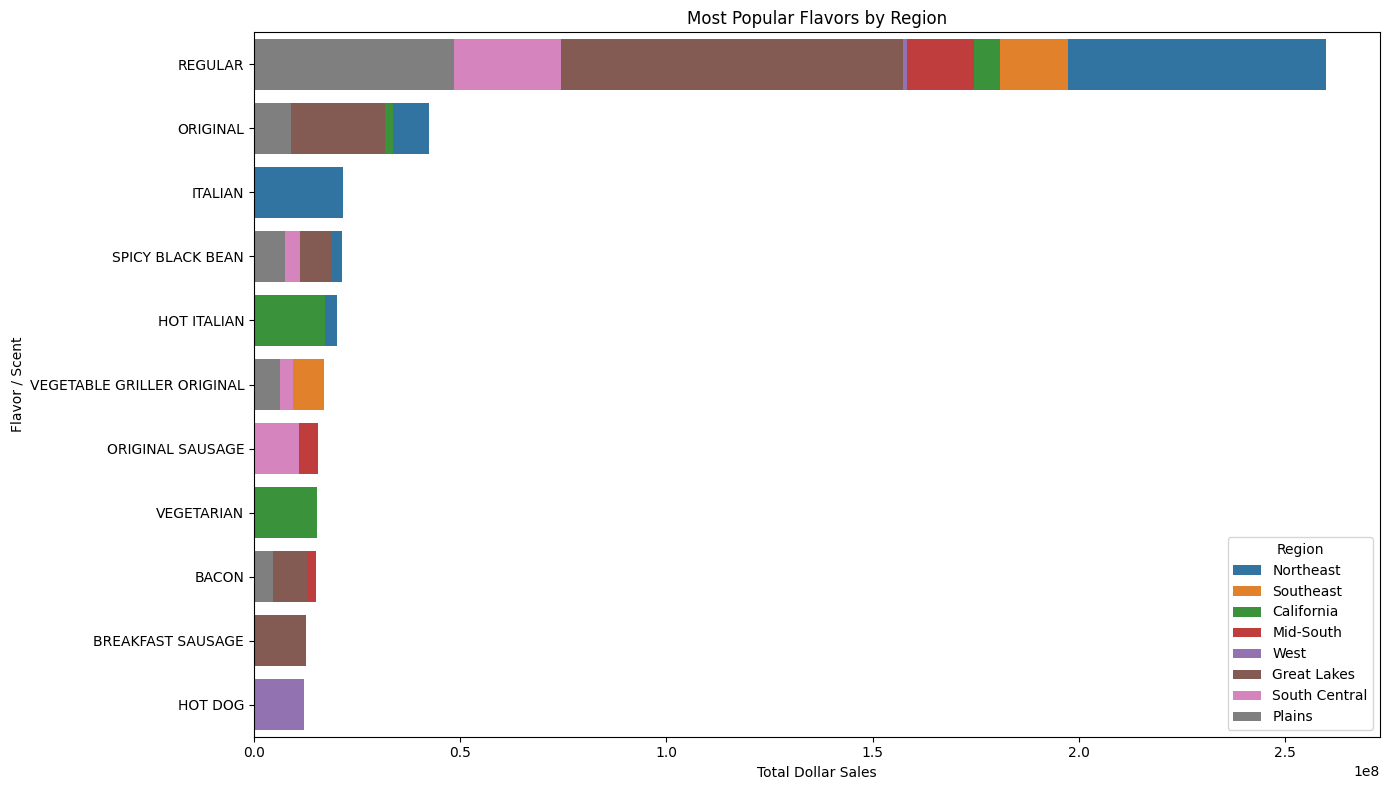

In [559]:
# 3. Most Popular Flavors by Region
flavor_region = combined_df.groupby(['Geography', 'Flavor / Scent'])['Dollar Sales'].sum().reset_index()
flavor_region_top = flavor_region.sort_values(by='Dollar Sales', ascending=False).groupby('Geography').head(5)
plt.figure(figsize=(14, 8))
sns.barplot(data=flavor_region_top, x='Dollar Sales', y='Flavor / Scent', hue='Geography', dodge=False)
plt.title('Most Popular Flavors by Region')
plt.xlabel('Total Dollar Sales')
plt.ylabel('Flavor / Scent')
plt.legend(title='Region')
plt.tight_layout()
plt.show()


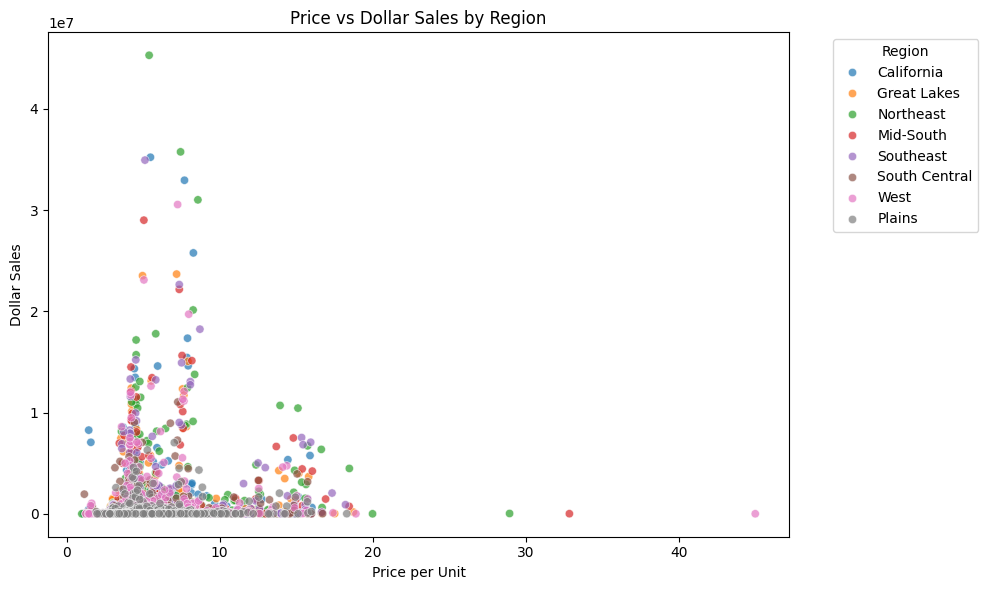

In [560]:
# 4. Price and Dollar Sales Relationship by Region
plt.figure(figsize=(10, 6))
sns.scatterplot(data=combined_df, x='Price per Unit', y='Dollar Sales', hue='Geography', alpha=0.7)
plt.title('Price vs Dollar Sales by Region')
plt.xlabel('Price per Unit')
plt.ylabel('Dollar Sales')
plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


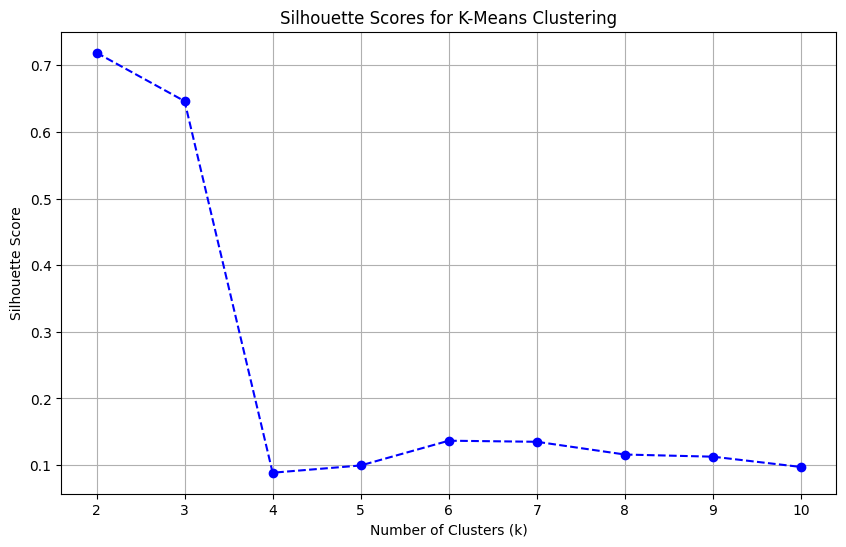

In [561]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import pandas as pd

# Select numerical and categorical features
numerical_features = ['Dollar Sales', 'Unit Sales', 'Volume Sales', 'ACV Weighted Distribution']
categorical_features = ['Package', 'Form', 'Flavor / Scent']

# Preprocessing: Standardize numerical features and one-hot encode categorical features
scaler = StandardScaler()
one_hot_encoder = OneHotEncoder(drop='first')

preprocessor = ColumnTransformer([
    ('num', scaler, numerical_features),
    ('cat', one_hot_encoder, categorical_features)
])

# Apply transformations
processed_data = preprocessor.fit_transform(combined_df)

# Range of clusters to evaluate
range_clusters = range(2, 11)
silhouette_scores = []

# Perform K-Means and calculate silhouette scores for each k
for k in range_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(processed_data)
    score = silhouette_score(processed_data, cluster_labels)
    silhouette_scores.append(score)

# Plot the silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(range_clusters, silhouette_scores, marker='o', linestyle='--', color='b')
plt.title('Silhouette Scores for K-Means Clustering')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid()
plt.show()


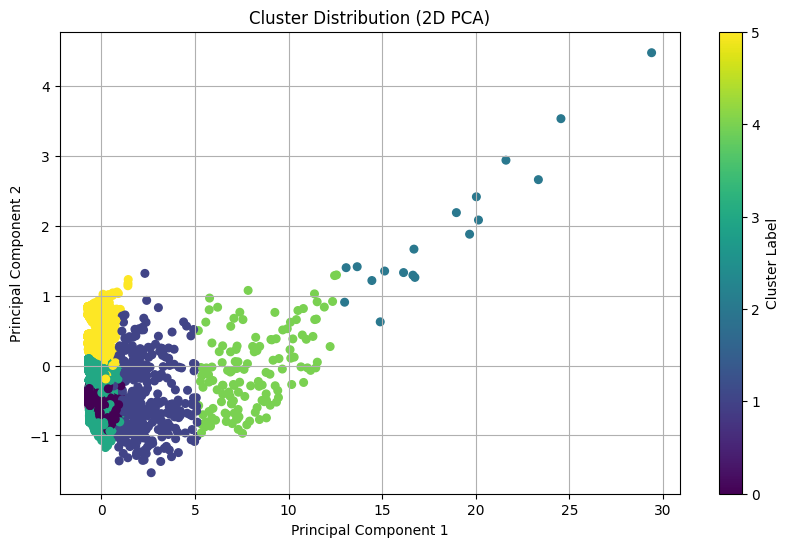

In [562]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Apply PCA to reduce the dimensions to 2
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(processed_data)

# Perform clustering with optimal k
optimal_k = 6
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = kmeans.fit_predict(processed_data)
combined_df['Cluster'] = cluster_labels

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=cluster_labels, cmap='viridis', s=30)
plt.title('Cluster Distribution (2D PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster Label')
plt.grid()
plt.show()


In [564]:
# Filter data for California
california_data = combined_df[combined_df['Geography'] == 'California']

# Updated numerical and categorical features
numerical_features = ['Dollar Sales', 'Unit Sales', 'Volume Sales', 'ACV Weighted Distribution']
categorical_features = ['Package', 'Form', 'Flavor / Scent']

# Preprocessing: Standardize numerical features
scaler = StandardScaler()
normalized_numerical = scaler.fit_transform(california_data[numerical_features])

# Perform K-Means clustering
kmeans = KMeans(n_clusters=6, random_state=42)
california_data['Cluster'] = kmeans.fit_predict(normalized_numerical)

# Summarize clustering results
cluster_summary = california_data.groupby('Cluster').agg({
    'Geography': 'first',  
    'Dollar Sales': 'mean',  
    'Package': lambda x: x.mode()[0] if not x.mode().empty else None,  
    'Form': lambda x: x.mode()[0] if not x.mode().empty else None,  
    'Flavor / Scent': lambda x: x.mode()[0] if not x.mode().empty else None,  
    'ACV Weighted Distribution': 'mean'  # Average distribution
}).reset_index()

C:\Users\v-pobank\AppData\Local\Temp\ipykernel_36812\904483121.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  california_data['Cluster'] = kmeans.fit_predict(normalized_numerical)


In [565]:
print(cluster_summary)

   Cluster   Geography  Dollar Sales                 Package    Form  \
0        0  California  2.000593e+06  RESEALABLE PLASTIC BAG  BURGER   
1        1  California  1.277897e+07                     BOX    LINK   
2        2  California  5.116600e+06  RESEALABLE PLASTIC BAG  BURGER   
3        3  California  3.132045e+07           VACUUM PACKED  GROUND   
4        4  California  1.300138e+05                     BOX  BURGER   
5        5  California  7.666258e+06         PLASTIC WRAPPED    ROLL   

  Flavor / Scent  ACV Weighted Distribution  
0        REGULAR                  20.699248  
1       ORIGINAL                  56.074852  
2        REGULAR                  42.045337  
3        REGULAR                  59.383506  
4        REGULAR                   2.169814  
5     VEGETARIAN                  40.356664  


In [566]:
# Rename columns for better readability
cluster_summary.columns = [
    'Cluster',
    'Region',
    'Average Dollar Sales',
    'Most Common Package',
    'Most Common Form',
    'Most Common Flavor/Scent',
    'Average ACV Weighted Distribution'
]

# Format numerical columns for better readability
cluster_summary['Average Dollar Sales'] = cluster_summary['Average Dollar Sales'].apply(lambda x: f"${x:,.2f}")
cluster_summary['Average ACV Weighted Distribution'] = cluster_summary['Average ACV Weighted Distribution'].round(2)

# Display the formatted summary
print("Enhanced California Cluster Summary:")
print(cluster_summary.to_string(index=False))

Enhanced California Cluster Summary:
 Cluster     Region Average Dollar Sales    Most Common Package Most Common Form Most Common Flavor/Scent  Average ACV Weighted Distribution
       0 California        $2,000,592.52 RESEALABLE PLASTIC BAG           BURGER                  REGULAR                              20.70
       1 California       $12,778,966.50                    BOX             LINK                 ORIGINAL                              56.07
       2 California        $5,116,599.75 RESEALABLE PLASTIC BAG           BURGER                  REGULAR                              42.05
       3 California       $31,320,445.48          VACUUM PACKED           GROUND                  REGULAR                              59.38
       4 California          $130,013.84                    BOX           BURGER                  REGULAR                               2.17
       5 California        $7,666,258.39        PLASTIC WRAPPED             ROLL               VEGETARIAN            

In [567]:
Great_Lakes_data = combined_df[combined_df['Geography'] == 'Great Lakes']

# Updated numerical and categorical features
numerical_features = ['Dollar Sales', 'Unit Sales', 'Volume Sales', 'ACV Weighted Distribution']
categorical_features = ['Package', 'Form', 'Flavor / Scent']

# Preprocessing: Standardize numerical features
scaler = StandardScaler()
normalized_numerical = scaler.fit_transform(Great_Lakes_data[numerical_features])

# Perform K-Means clustering
kmeans = KMeans(n_clusters=6, random_state=42)
Great_Lakes_data['Cluster'] = kmeans.fit_predict(normalized_numerical)

# Summarize clustering results
cluster_summary = Great_Lakes_data.groupby('Cluster').agg({
    'Geography': 'first', 
    'Dollar Sales': 'mean', 
    'Package': lambda x: x.mode()[0] if not x.mode().empty else None,  
    'Form': lambda x: x.mode()[0] if not x.mode().empty else None,  
    'Flavor / Scent': lambda x: x.mode()[0] if not x.mode().empty else None,  
    'ACV Weighted Distribution': 'mean'
}).reset_index()

C:\Users\v-pobank\AppData\Local\Temp\ipykernel_36812\1332434214.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Great_Lakes_data['Cluster'] = kmeans.fit_predict(normalized_numerical)


In [568]:
# Rename columns for better readability
cluster_summary.columns = [
    'Cluster',
    'Region',
    'Average Dollar Sales',
    'Most Common Package',
    'Most Common Form',
    'Most Common Flavor/Scent',
    'Average ACV Weighted Distribution'
]

# Format numerical columns for better readability
cluster_summary['Average Dollar Sales'] = cluster_summary['Average Dollar Sales'].apply(lambda x: f"${x:,.2f}")
cluster_summary['Average ACV Weighted Distribution'] = cluster_summary['Average ACV Weighted Distribution'].round(2)

# Display the formatted summary
print("Enhanced Great Lakes Cluster Summary:")
print(cluster_summary.to_string(index=False))

Enhanced Great Lakes Cluster Summary:
 Cluster      Region Average Dollar Sales         Most Common Package Most Common Form Most Common Flavor/Scent  Average ACV Weighted Distribution
       0 Great Lakes        $1,906,622.60      RESEALABLE PLASTIC BAG           BURGER                  REGULAR                              16.18
       1 Great Lakes          $116,174.02                         BOX           BURGER                  REGULAR                               1.65
       2 Great Lakes        $6,647,132.30      RESEALABLE PLASTIC BAG           BURGER   ALL AMERICAN VEGETABLE                              45.61
       3 Great Lakes       $23,604,106.36 PLASTIC CONTAINER IN SLEEVE     BURGER PATTY                  REGULAR                              48.02
       4 Great Lakes       $11,863,513.07                 PLASTIC BAG           GROUND                  REGULAR                              42.46
       5 Great Lakes       $11,624,161.03                         BOX           

In [569]:
combined_df['Geography'].unique()

array(['California', 'Great Lakes', 'Northeast', 'Mid-South', 'Southeast',
       'South Central', 'West', 'Plains'], dtype=object)

In [570]:
Northeast_data = combined_df[combined_df['Geography'] == 'Northeast']

# Updated numerical and categorical features
numerical_features = ['Dollar Sales', 'Unit Sales', 'Volume Sales', 'ACV Weighted Distribution']
categorical_features = ['Package', 'Form', 'Flavor / Scent']

# Preprocessing: Standardize numerical features
scaler = StandardScaler()
normalized_numerical = scaler.fit_transform(Northeast_data[numerical_features])

# Perform K-Means clustering
kmeans = KMeans(n_clusters=6, random_state=42)
Northeast_data['Cluster'] = kmeans.fit_predict(normalized_numerical)

# Summarize clustering results
cluster_summary = Northeast_data.groupby('Cluster').agg({
    'Geography': 'first',  
    'Dollar Sales': 'mean',  
    'Package': lambda x: x.mode()[0] if not x.mode().empty else None,  
    'Form': lambda x: x.mode()[0] if not x.mode().empty else None,  
    'Flavor / Scent': lambda x: x.mode()[0] if not x.mode().empty else None,  
    'ACV Weighted Distribution': 'mean' 
}).reset_index()

C:\Users\v-pobank\AppData\Local\Temp\ipykernel_36812\3275752888.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Northeast_data['Cluster'] = kmeans.fit_predict(normalized_numerical)


In [571]:
# Rename columns for better readability
cluster_summary.columns = [
    'Cluster',
    'Region',
    'Average Dollar Sales',
    'Most Common Package',
    'Most Common Form',
    'Most Common Flavor/Scent',
    'Average ACV Weighted Distribution'
]

# Format numerical columns for better readability
cluster_summary['Average Dollar Sales'] = cluster_summary['Average Dollar Sales'].apply(lambda x: f"${x:,.2f}")
cluster_summary['Average ACV Weighted Distribution'] = cluster_summary['Average ACV Weighted Distribution'].round(2)

# Display the formatted summary
print("Enhanced Northeast Cluster Summary:")
print(cluster_summary.to_string(index=False))

Enhanced Northeast Cluster Summary:
 Cluster    Region Average Dollar Sales         Most Common Package Most Common Form Most Common Flavor/Scent  Average ACV Weighted Distribution
       0 Northeast          $174,570.39                         BOX           BURGER                  REGULAR                               1.75
       1 Northeast       $25,579,274.15           PLASTIC WRAP TRAY           GROUND              HOT ITALIAN                              42.93
       2 Northeast        $8,088,213.83      RESEALABLE PLASTIC BAG           BURGER                  REGULAR                              35.81
       3 Northeast        $2,252,338.10                         BOX           BURGER                  REGULAR                              14.86
       4 Northeast       $40,532,772.79 PLASTIC CONTAINER IN SLEEVE     BURGER PATTY                  REGULAR                              50.86
       5 Northeast       $13,140,072.28      RESEALABLE PLASTIC BAG           BURGER          

In [572]:
Mid_South_data = combined_df[combined_df['Geography'] == 'Mid-South']

# Updated numerical and categorical features
numerical_features = ['Dollar Sales', 'Unit Sales', 'Volume Sales', 'ACV Weighted Distribution']
categorical_features = ['Package', 'Form', 'Flavor / Scent']

# Preprocessing: Standardize numerical features
scaler = StandardScaler()
normalized_numerical = scaler.fit_transform(Mid_South_data[numerical_features])

# Perform K-Means clustering
kmeans = KMeans(n_clusters=6, random_state=42)
Mid_South_data['Cluster'] = kmeans.fit_predict(normalized_numerical)

# Summarize clustering results
cluster_summary = Mid_South_data.groupby('Cluster').agg({
    'Geography': 'first',  
    'Dollar Sales': 'mean', 
    'Package': lambda x: x.mode()[0] if not x.mode().empty else None, 
    'Form': lambda x: x.mode()[0] if not x.mode().empty else None,  
    'Flavor / Scent': lambda x: x.mode()[0] if not x.mode().empty else None, 
    'ACV Weighted Distribution': 'mean' 
}).reset_index()

C:\Users\v-pobank\AppData\Local\Temp\ipykernel_36812\1375878505.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Mid_South_data['Cluster'] = kmeans.fit_predict(normalized_numerical)


In [573]:
# Rename columns for better readability
cluster_summary.columns = [
    'Cluster',
    'Region',
    'Average Dollar Sales',
    'Most Common Package',
    'Most Common Form',
    'Most Common Flavor/Scent',
    'Average ACV Weighted Distribution'
]

# Format numerical columns for better readability
cluster_summary['Average Dollar Sales'] = cluster_summary['Average Dollar Sales'].apply(lambda x: f"${x:,.2f}")
cluster_summary['Average ACV Weighted Distribution'] = cluster_summary['Average ACV Weighted Distribution'].round(2)

# Display the formatted summary
print("Enhanced Mid-South Cluster Summary:")
print(cluster_summary.to_string(index=False))


Enhanced Mid-South Cluster Summary:
 Cluster    Region Average Dollar Sales         Most Common Package Most Common Form Most Common Flavor/Scent  Average ACV Weighted Distribution
       0 Mid-South        $1,591,484.09      RESEALABLE PLASTIC BAG           BURGER                  REGULAR                              13.97
       1 Mid-South       $11,120,180.24           PLASTIC WRAP TRAY             LINK              HOT ITALIAN                              30.86
       2 Mid-South          $119,875.15                         BOX           BURGER                  REGULAR                               1.46
       3 Mid-South       $25,593,760.13 PLASTIC CONTAINER IN SLEEVE     BURGER PATTY                  REGULAR                              43.66
       4 Mid-South       $10,160,621.30      RESEALABLE PLASTIC BAG           BURGER                  REGULAR                              52.57
       5 Mid-South        $5,112,986.58      RESEALABLE PLASTIC BAG           BURGER          

In [574]:
Southeast_data = combined_df[combined_df['Geography'] == 'Southeast']

# Updated numerical and categorical features
numerical_features = ['Dollar Sales', 'Unit Sales', 'Volume Sales', 'ACV Weighted Distribution']
categorical_features = ['Package', 'Form', 'Flavor / Scent']

# Preprocessing: Standardize numerical features
scaler = StandardScaler()
normalized_numerical = scaler.fit_transform(Southeast_data[numerical_features])

# Perform K-Means clustering
kmeans = KMeans(n_clusters=6, random_state=42)
Southeast_data['Cluster'] = kmeans.fit_predict(normalized_numerical)

# Summarize clustering results
cluster_summary = Southeast_data.groupby('Cluster').agg({
    'Geography': 'first',  
    'Dollar Sales': 'mean',  
    'Package': lambda x: x.mode()[0] if not x.mode().empty else None,  
    'Form': lambda x: x.mode()[0] if not x.mode().empty else None,  
    'Flavor / Scent': lambda x: x.mode()[0] if not x.mode().empty else None, 
    'ACV Weighted Distribution': 'mean'  
}).reset_index()

C:\Users\v-pobank\AppData\Local\Temp\ipykernel_36812\2183316836.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Southeast_data['Cluster'] = kmeans.fit_predict(normalized_numerical)


In [575]:
# Rename columns for better readability
cluster_summary.columns = [
    'Cluster',
    'Region',
    'Average Dollar Sales',
    'Most Common Package',
    'Most Common Form',
    'Most Common Flavor/Scent',
    'Average ACV Weighted Distribution'
]

# Format numerical columns for better readability
cluster_summary['Average Dollar Sales'] = cluster_summary['Average Dollar Sales'].apply(lambda x: f"${x:,.2f}")
cluster_summary['Average ACV Weighted Distribution'] = cluster_summary['Average ACV Weighted Distribution'].round(2)

# Display the formatted summary
print("Enhanced Southeast Cluster Summary:")
print(cluster_summary.to_string(index=False))

Enhanced Southeast Cluster Summary:
 Cluster    Region Average Dollar Sales         Most Common Package Most Common Form Most Common Flavor/Scent  Average ACV Weighted Distribution
       0 Southeast           $96,607.48                         BOX           BURGER                  REGULAR                               0.90
       1 Southeast       $13,911,282.91               VACUUM PACKED             LINK                  REGULAR                              46.60
       2 Southeast        $7,007,611.00      RESEALABLE PLASTIC BAG           BURGER         SPICY BLACK BEAN                              44.21
       3 Southeast       $34,945,195.53 PLASTIC CONTAINER IN SLEEVE     BURGER PATTY                  REGULAR                              50.80
       4 Southeast          $963,159.02                         BOX           BURGER                  REGULAR                              10.26
       5 Southeast        $3,450,590.24      RESEALABLE PLASTIC BAG           BURGER          

In [576]:
South_Central_data = combined_df[combined_df['Geography'] == 'South Central']

# Updated numerical and categorical features
numerical_features = ['Dollar Sales', 'Unit Sales', 'Volume Sales', 'ACV Weighted Distribution']
categorical_features = ['Package', 'Form', 'Flavor / Scent']

# Preprocessing: Standardize numerical features
scaler = StandardScaler()
normalized_numerical = scaler.fit_transform(South_Central_data[numerical_features])

# Perform K-Means clustering
kmeans = KMeans(n_clusters=6, random_state=42)
South_Central_data['Cluster'] = kmeans.fit_predict(normalized_numerical)

# Summarize clustering results
cluster_summary = South_Central_data.groupby('Cluster').agg({
    'Geography': 'first',  
    'Dollar Sales': 'mean',  
    'Package': lambda x: x.mode()[0] if not x.mode().empty else None, 
    'Form': lambda x: x.mode()[0] if not x.mode().empty else None, 
    'Flavor / Scent': lambda x: x.mode()[0] if not x.mode().empty else None,  
    'ACV Weighted Distribution': 'mean'  
}).reset_index()

C:\Users\v-pobank\AppData\Local\Temp\ipykernel_36812\1722477331.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  South_Central_data['Cluster'] = kmeans.fit_predict(normalized_numerical)


In [577]:
# Rename columns for better readability
cluster_summary.columns = [
    'Cluster',
    'Region',
    'Average Dollar Sales',
    'Most Common Package',
    'Most Common Form',
    'Most Common Flavor/Scent',
    'Average ACV Weighted Distribution'
]

# Format numerical columns for better readability
cluster_summary['Average Dollar Sales'] = cluster_summary['Average Dollar Sales'].apply(lambda x: f"${x:,.2f}")
cluster_summary['Average ACV Weighted Distribution'] = cluster_summary['Average ACV Weighted Distribution'].round(2)

# Display the formatted summary
print("Enhanced South Central Cluster Summary:")
print(cluster_summary.to_string(index=False))

Enhanced South Central Cluster Summary:
 Cluster        Region Average Dollar Sales    Most Common Package        Most Common Form Most Common Flavor/Scent  Average ACV Weighted Distribution
       0 South Central          $810,205.63                    BOX                  BURGER                  REGULAR                              10.73
       1 South Central           $56,745.23                    BOX                  BURGER                  REGULAR                               1.12
       2 South Central        $3,428,859.66 RESEALABLE PLASTIC BAG                  BURGER   ALL AMERICAN VEGETABLE                              33.71
       3 South Central       $10,044,353.77            PLASTIC BAG BREAKFAST SAUSAGE PATTY         ORIGINAL SAUSAGE                              51.90
       4 South Central        $6,530,472.23                    BOX                  BURGER                  REGULAR                              40.64
       5 South Central        $2,819,811.04 RESEALABLE

In [578]:
West_data = combined_df[combined_df['Geography'] == 'West']

# Updated numerical and categorical features
numerical_features = ['Dollar Sales', 'Unit Sales', 'Volume Sales', 'ACV Weighted Distribution']
categorical_features = ['Package', 'Form', 'Flavor / Scent']

# Preprocessing: Standardize numerical features
scaler = StandardScaler()
normalized_numerical = scaler.fit_transform(West_data[numerical_features])

# Perform K-Means clustering
kmeans = KMeans(n_clusters=6, random_state=42)
West_data['Cluster'] = kmeans.fit_predict(normalized_numerical)

# Summarize clustering results
cluster_summary = West_data.groupby('Cluster').agg({
    'Geography': 'first',  
    'Dollar Sales': 'mean',  
    'Package': lambda x: x.mode()[0] if not x.mode().empty else None, 
    'Form': lambda x: x.mode()[0] if not x.mode().empty else None,  
    'Flavor / Scent': lambda x: x.mode()[0] if not x.mode().empty else None, 
    'ACV Weighted Distribution': 'mean'  
}).reset_index()

C:\Users\v-pobank\AppData\Local\Temp\ipykernel_36812\4099281762.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  West_data['Cluster'] = kmeans.fit_predict(normalized_numerical)


In [579]:
# Rename columns for better readability
cluster_summary.columns = [
    'Cluster',
    'Region',
    'Average Dollar Sales',
    'Most Common Package',
    'Most Common Form',
    'Most Common Flavor/Scent',
    'Average ACV Weighted Distribution'
]

# Format numerical columns for better readability
cluster_summary['Average Dollar Sales'] = cluster_summary['Average Dollar Sales'].apply(lambda x: f"${x:,.2f}")
cluster_summary['Average ACV Weighted Distribution'] = cluster_summary['Average ACV Weighted Distribution'].round(2)

# Display the formatted summary
print("Enhanced West Cluster Summary:")
print(cluster_summary.to_string(index=False))

Enhanced West Cluster Summary:
 Cluster Region Average Dollar Sales    Most Common Package Most Common Form Most Common Flavor/Scent  Average ACV Weighted Distribution
       0   West           $78,549.63                    BOX           BURGER                  REGULAR                               1.42
       1   West        $7,742,895.24 RESEALABLE PLASTIC BAG             LINK                  REGULAR                              51.87
       2   West        $3,488,577.81 RESEALABLE PLASTIC BAG           BURGER                  REGULAR                              30.91
       3   West       $24,461,238.41          VACUUM PACKED           GROUND                  REGULAR                              54.13
       4   West        $1,060,303.54 RESEALABLE PLASTIC BAG           BURGER                  REGULAR                              14.09
       5   West       $10,891,173.19                    BOX  BREAKFAST PATTY                    BACON                              57.93


In [580]:
Plains_data = combined_df[combined_df['Geography'] == 'Plains']

# Updated numerical and categorical features
numerical_features = ['Dollar Sales', 'Unit Sales', 'Volume Sales', 'ACV Weighted Distribution']
categorical_features = ['Package', 'Form', 'Flavor / Scent']

# Preprocessing: Standardize numerical features
scaler = StandardScaler()
normalized_numerical = scaler.fit_transform(Plains_data[numerical_features])

# Perform K-Means clustering
kmeans = KMeans(n_clusters=6, random_state=42)
Plains_data['Cluster'] = kmeans.fit_predict(normalized_numerical)

# Summarize clustering results
cluster_summary = Plains_data.groupby('Cluster').agg({
    'Geography': 'first',  
    'Dollar Sales': 'mean',  
    'Package': lambda x: x.mode()[0] if not x.mode().empty else None, 
    'Form': lambda x: x.mode()[0] if not x.mode().empty else None,  
    'Flavor / Scent': lambda x: x.mode()[0] if not x.mode().empty else None,  
    'ACV Weighted Distribution': 'mean'  
}).reset_index()

C:\Users\v-pobank\AppData\Local\Temp\ipykernel_36812\2498842102.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Plains_data['Cluster'] = kmeans.fit_predict(normalized_numerical)


In [581]:
# Rename columns for better readability
cluster_summary.columns = [
    'Cluster',
    'Region',
    'Average Dollar Sales',
    'Most Common Package',
    'Most Common Form',
    'Most Common Flavor/Scent',
    'Average ACV Weighted Distribution'
]

# Format numerical columns for better readability
cluster_summary['Average Dollar Sales'] = cluster_summary['Average Dollar Sales'].apply(lambda x: f"${x:,.2f}")
cluster_summary['Average ACV Weighted Distribution'] = cluster_summary['Average ACV Weighted Distribution'].round(2)

# Display the formatted summary
print("Enhanced Plains Cluster Summary:")
print(cluster_summary.to_string(index=False))

Enhanced Plains Cluster Summary:
 Cluster Region Average Dollar Sales    Most Common Package Most Common Form Most Common Flavor/Scent  Average ACV Weighted Distribution
       0 Plains          $197,578.36                    BOX           BURGER                  REGULAR                               4.30
       1 Plains        $3,090,057.08 RESEALABLE PLASTIC BAG           BURGER                  REGULAR                              34.57
       2 Plains          $587,799.47 RESEALABLE PLASTIC BAG           BURGER                  REGULAR                              10.07
       3 Plains        $5,271,615.07                    BOX           GROUND                  REGULAR                              42.53
       4 Plains           $17,277.42                    BOX           BURGER                  REGULAR                               0.69
       5 Plains        $1,652,585.21 RESEALABLE PLASTIC BAG             LINK                 ORIGINAL                              23.09


In [582]:
# Load the dataset
file_path = 'combined_data.csv'  
combined_df = pd.read_csv(file_path)
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5315 entries, 0 to 5314
Data columns (total 26 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   UPC 13 digit                      5315 non-null   int64  
 1   Geography                         5315 non-null   object 
 2   Time                              5315 non-null   object 
 3   Product_x                         5315 non-null   object 
 4   Unit Sales                        5315 non-null   float64
 5   Volume Sales                      5315 non-null   float64
 6   Dollar Sales                      5315 non-null   float64
 7   Total Ounces                      5315 non-null   float64
 8   Price per Unit                    5315 non-null   float64
 9   Package                           5315 non-null   object 
 10  Cooked Info                       5315 non-null   object 
 11  Price per Volume                  5315 non-null   float64
 12  Unit S

In [583]:
# Remove unnecessary text and parse the date
combined_df['Time'] = combined_df['Time'].str.replace('Week Ending', '').str.strip()
combined_df['Time'] = pd.to_datetime(combined_df['Time'], format='%m-%d-%y', errors='coerce')


In [584]:
# Check for parsing errors
print(combined_df[combined_df['Time'].isna()])

Empty DataFrame
Columns: [UPC 13 digit, Geography, Time, Product_x, Unit Sales, Volume Sales, Dollar Sales, Total Ounces, Price per Unit, Package, Cooked Info, Price per Volume, Unit Sales Any Merch, Unit Sales Price Reductions Only, Unit Sales Feature Only, Unit Sales Display Only, Dollar Sales Any Merch, Dollar Sales Feature Only, Dollar Sales Display Only, Incremental Units, Incremental Volume, Incremental Dollars, ACV Weighted Distribution, Flavor / Scent, Form, Brand Name]
Index: []

[0 rows x 26 columns]


In [585]:
combined_df['Year'] = combined_df['Time'].dt.year
combined_df['Month'] = combined_df['Time'].dt.month
combined_df['Quarter'] = combined_df['Time'].dt.quarter


In [586]:
def assign_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

combined_df['Season'] = combined_df['Month'].apply(assign_season)


In [587]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5315 entries, 0 to 5314
Data columns (total 30 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   UPC 13 digit                      5315 non-null   int64         
 1   Geography                         5315 non-null   object        
 2   Time                              5315 non-null   datetime64[ns]
 3   Product_x                         5315 non-null   object        
 4   Unit Sales                        5315 non-null   float64       
 5   Volume Sales                      5315 non-null   float64       
 6   Dollar Sales                      5315 non-null   float64       
 7   Total Ounces                      5315 non-null   float64       
 8   Price per Unit                    5315 non-null   float64       
 9   Package                           5315 non-null   object        
 10  Cooked Info                       5315 non-null 

In [588]:
seasonal_sales = combined_df.groupby(['Season', 'Geography'])['Dollar Sales'].sum().reset_index()
print(seasonal_sales)

# Pivot table for better visualization
seasonal_sales_pivot = seasonal_sales.pivot(index='Geography', columns='Season', values='Dollar Sales')
print(seasonal_sales_pivot)


    Season      Geography  Dollar Sales
0     Fall     California  2.501035e+07
1     Fall    Great Lakes  2.623108e+07
2     Fall      Mid-South  2.764319e+07
3     Fall      Northeast  4.680815e+07
4     Fall         Plains  1.062294e+07
5     Fall  South Central  1.532322e+07
6     Fall      Southeast  2.904269e+07
7     Fall           West  2.651867e+07
8   Spring     California  3.864318e+07
9   Spring    Great Lakes  6.930486e+07
10  Spring      Mid-South  5.959501e+07
11  Spring      Northeast  8.721983e+07
12  Spring         Plains  1.989488e+07
13  Spring  South Central  3.471069e+07
14  Spring      Southeast  6.345780e+07
15  Spring           West  6.574530e+07
16  Summer     California  2.472610e+07
17  Summer    Great Lakes  2.679667e+07
18  Summer      Mid-South  2.578809e+07
19  Summer      Northeast  1.392183e+07
20  Summer         Plains  7.320766e+06
21  Summer  South Central  7.040625e+06
22  Summer      Southeast  2.177361e+07
23  Summer           West  2.369116e+07


In [589]:
seasonal_flavor_distribution = combined_df.groupby(['Season', 'Flavor / Scent']).size().reset_index(name='Count')
seasonal_form_distribution = combined_df.groupby(['Season', 'Form']).size().reset_index(name='Count')

print(seasonal_flavor_distribution)
print(seasonal_form_distribution)


     Season                      Flavor / Scent  Count
0      Fall                     APPLEWOOD SMOKE      4
1      Fall                           ARTICHOKE      7
2      Fall                               ASIAN      1
3      Fall                               BACON      5
4      Fall                            BARBEQUE      5
..      ...                                 ...    ...
562  Winter                    WHITE BEAN CHILI      5
563  Winter                       WILD MUSHROOM     13
564  Winter  WILD MUSHROOM CAULIFLOWER HEMPSEED      7
565  Winter                       ZESTY ITALIAN     19
566  Winter                       ZESTY MEXICAN      5

[567 rows x 3 columns]
     Season              Form  Count
0      Fall              BALL     19
1      Fall           BAO BUN      1
2      Fall             BINGS      1
3      Fall              BITE      8
4      Fall             BLOCK      3
..      ...               ...    ...
148  Winter        SPLIT ROPE      3
149  Winter         

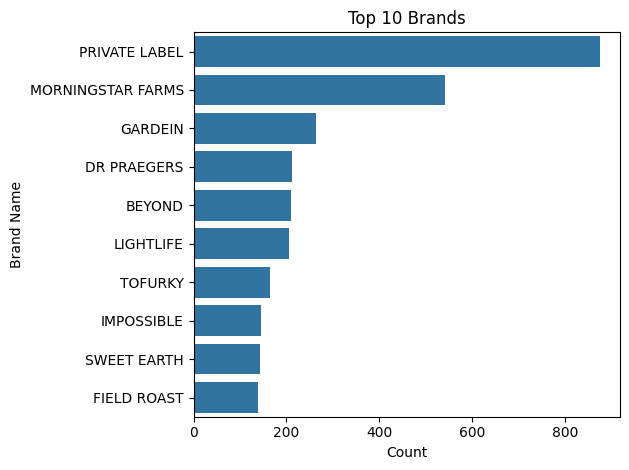

In [590]:
import seaborn as sns
import matplotlib.pyplot as plt

# Identify the top 10 brands
top_brands = combined_df['Brand Name'].value_counts().head(10).index

# Filter the data to include only the top 10 brands
top_brand_data = combined_df[combined_df['Brand Name'].isin(top_brands)]

# Create a countplot for top brands
sns.countplot(data=top_brand_data, y='Brand Name', order=top_brands)
plt.title('Top 10 Brands')
plt.xlabel('Count')
plt.ylabel('Brand Name')
plt.tight_layout()
plt.show()


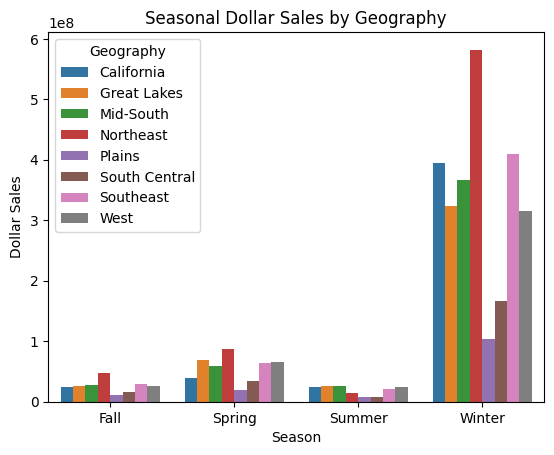

In [591]:
import seaborn as sns
import matplotlib.pyplot as plt

# Seasonal Dollar Sales by Geography
sns.barplot(data=seasonal_sales, x='Season', y='Dollar Sales', hue='Geography')
plt.title('Seasonal Dollar Sales by Geography')
plt.show()




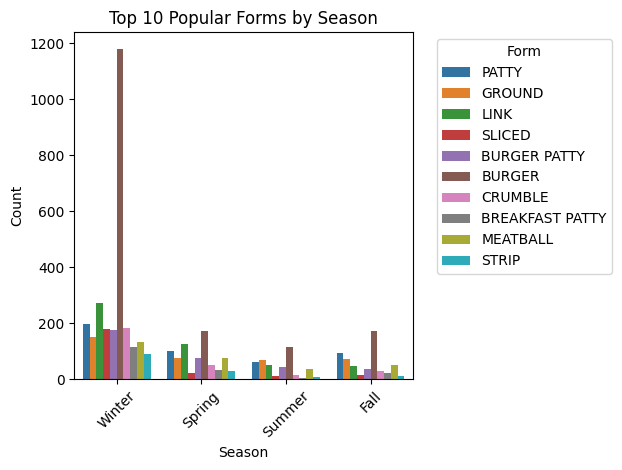

In [592]:
# Identify the top 10 forms across all seasons
top_forms = combined_df['Form'].value_counts().head(10).index

# Filter the data to include only the top 10 forms
top_form_data = combined_df[combined_df['Form'].isin(top_forms)]

# Group the data by season and form for visualization
sns.countplot(data=top_form_data, x='Season', hue='Form')
plt.title('Top 10 Popular Forms by Season')
plt.xlabel('Season')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Form', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


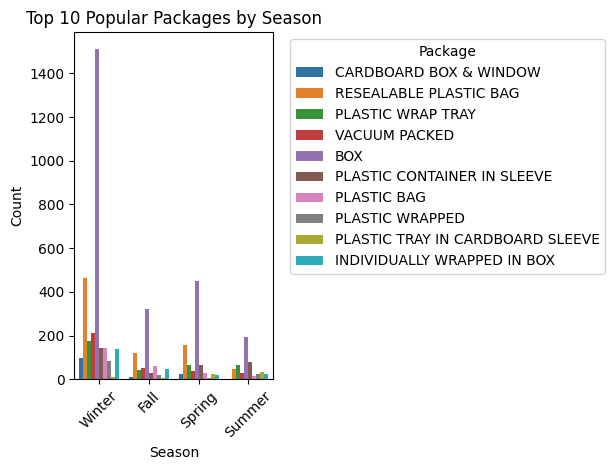

In [593]:
# Identify the top 10 packages across all seasons
top_packages =combined_df['Package'].value_counts().head(10).index

# Filter the data to include only the top 10 packages
top_package_data = combined_df[combined_df['Package'].isin(top_packages)]

# Group the data by season and package for visualization
sns.countplot(data=top_package_data, x='Season', hue='Package')
plt.title('Top 10 Popular Packages by Season')
plt.xlabel('Season')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Package', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


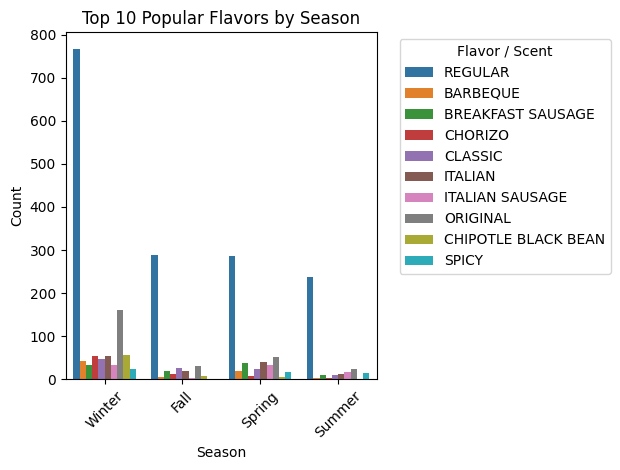

In [594]:
# Identify the top 10 flavors across all seasons
top_flavors = combined_df['Flavor / Scent'].value_counts().head(10).index

# Filter the data to include only the top 10 flavors
top_flavor_data = combined_df[combined_df['Flavor / Scent'].isin(top_flavors)]

# Group the data by season and flavor for visualization
sns.countplot(data=top_flavor_data, x='Season', hue='Flavor / Scent')
plt.title('Top 10 Popular Flavors by Season')
plt.xlabel('Season')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Flavor / Scent', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [595]:
from scipy.stats import f_oneway

# Perform ANOVA for each attribute
attributes = ['Flavor / Scent', 'Form', 'Package']
for attr in attributes:
    # Group sales data by the attribute and season
    seasonal_sales = [
        combined_df[combined_df['Season'] == season].groupby(attr)['Dollar Sales'].mean()
        for season in combined_df['Season'].unique()
    ]
    
    # Perform ANOVA
    f_stat, p_value = f_oneway(*seasonal_sales)
    print(f"ANOVA for {attr}:")
    print("F-statistic:", f_stat)
    print("P-value:", p_value)
    if p_value < 0.05:
        print(f"{attr} shows significant seasonal effects on Dollar Sales.")
    else:
        print(f"{attr} does not show significant seasonal effects on Dollar Sales.")
    print()


ANOVA for Flavor / Scent:
F-statistic: 5.645284013536097
P-value: 0.000814233223084044
Flavor / Scent shows significant seasonal effects on Dollar Sales.

ANOVA for Form:
F-statistic: 5.0173713354627845
P-value: 0.002422979725982653
Form shows significant seasonal effects on Dollar Sales.

ANOVA for Package:
F-statistic: 0.6353562664874648
P-value: 0.5950931342108804
Package does not show significant seasonal effects on Dollar Sales.



In [596]:
top_flavors = combined_df['Flavor / Scent'].value_counts().head(5).index
top_forms = combined_df['Form'].value_counts().head(5).index

In [597]:
filtered_df = combined_df[
    combined_df['Flavor / Scent'].isin(top_flavors) &
    combined_df['Form'].isin(top_forms)
]


In [598]:
filtered_df.rename(columns={'Flavor / Scent': 'Flavor_Scent'}, inplace=True)


C:\Users\v-pobank\AppData\Local\Temp\ipykernel_36812\1133859321.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.rename(columns={'Flavor / Scent': 'Flavor_Scent'}, inplace=True)


In [599]:
import statsmodels.formula.api as smf

formula = (
    'Q("Dollar Sales") ~ Q("ACV Weighted Distribution") + Q("Price per Unit") + '
    'C(Flavor_Scent) * C(Season) + C(Form) * C(Season)'
)

# Fit the regression model
model = smf.ols(formula=formula, data=filtered_df).fit()

# Print the summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:      Q("Dollar Sales")   R-squared:                       0.701
Model:                            OLS   Adj. R-squared:                  0.692
Method:                 Least Squares   F-statistic:                     78.20
Date:                Thu, 05 Dec 2024   Prob (F-statistic):          2.67e-293
Time:                        22:40:47   Log-Likelihood:                -20326.
No. Observations:                1273   AIC:                         4.073e+04
Df Residuals:                    1235   BIC:                         4.092e+04
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
                                                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------